In [2]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd

%matplotlib inline
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['savefig.dpi'] = 300

# Reaction Analysis in Batch and Continuous Flow Reactors
https://doi.org/10.1002/kin.20597

https://doi.org/10.1016/j.cep.2006.02.010 

Using the following soponification reaction as our experimental model
$${NaOH} + {EtOAc} \longrightarrow {NaOAC} + {EtOH}$$
$${A} + {B} \longrightarrow {C} + {D}$$

For the batch reaction, we operated under the following conditions:

$T_{Bath} = (25 °C, 30 °C, 35 °C)$

$C_{NaOH,0} \approx 0.05 mol/dm^3$

$C_{EtOAC,0} \approx 0.05 mol/dm^3$

## Batch Reactor

### Relating Concentration to Conductivity and temperature data

To find the concentrations of the reaction species at time $t$, we establish a relationship between concentration of our basis species, $C_A$, and total conductivity, $\Lambda_1$.

First, We approximate that only the ionic species, reactant A and product C, contribute to the measured total conductivity.

$$\Lambda_1 = \Lambda_{1A} + \Lambda_{1C}$$

Then we consider conductivity of a species as a function of partial concentration and system temperature.
Thus, $\Lambda_1i$ at a given time, $t$:

$$\Lambda_{1i}(t) = f(C_i(t), T_{sys}(t))$$
$$\Lambda_1 = \Lambda_{1A}(C_A, T) + \Lambda_{1C}(C_C, T)$$

Applying the system constraint that $C_C = f(C_A)$
$$C_A = C_{A0}(1-X_1)$$
$$C_C = C_{A0}X_1$$
We get
$$\Lambda_1(t) = f(C_A(t), (C_{A0} - C_A(t)), T(t)) => f(C_A(t), T(t))$$

Inverting and solving for $C_A(t)$:

$$C_A(t) = f(\Lambda_1(t), T(t))$$


In [3]:
# Saving tabulated values for partial conductivity
# Tabulated value data for each table: [(temperature, concentration, conductivity), ...]
data_NaOH_0_05 = [
    (20.5, 0.05, 11.14),
    (24.5, 0.05, 11.96),
    (25.5, 0.05, 12.16),
    (27.5, 0.05, 12.61),
    (29.7, 0.05, 13.07),
    (31.4, 0.05, 13.48),
    (33.4, 0.05, 13.93),
    (35.4, 0.05, 14.33)
]
data_NaOH_0_01 = [
    (22.5, 0.01, 1.98),
    (27.1, 0.01, 2.17),
    (28.1, 0.01, 2.20),
    (29.6, 0.01, 2.25),
    (31.3, 0.01, 2.33),
    (33.5, 0.01, 2.42),
    (35.4, 0.01, 2.45)
]
data_NaOH_0_001 = [
    (23.8, 0.001, 0.19),
    (26.9, 0.001, 0.20),
    (30.3, 0.001, 0.21),
    (31.4, 0.001, 0.21),
    (33.4, 0.001, 0.22),
    (35.4, 0.001, 0.23)
]

data_NaOAc_0_1 = [
    (24.9, 0.1, 7.04),
    (26.1, 0.1, 7.36),
    (27.6, 0.1, 7.78),
    (29.8, 0.1, 8.01),
    (31.4, 0.1, 8.33),
    (33.6, 0.1, 8.63),
    (33.5, 0.1, 9.09)
]
data_NaOAc_0_01 = [
    (21.7, 0.01, 0.68),
    (24.5, 0.01, 0.73),
    (25.8, 0.01, 0.75),
    (27.7, 0.01, 0.79),
    (29.7, 0.01, 0.81),
    (31.5, 0.01, 0.85),
    (33.5, 0.01, 0.89),
    (35.4, 0.01, 0.93)
]
data_NaOAc_0_001 = [
    (24.3, 0.001, 0.087),
    (30.5, 0.001, 0.10),
    (35.9, 0.001, 0.11)
]


In [4]:
# Reading in experimental batch data from excel file
run_data = pd.read_excel('Lab 1 Data Clean.xlsx', sheet_name=[0, 1, 2])

# print(run_data[1].columns)

run1_T = np.array(run_data[0]['Reactor \nTemp. \n \n[°C]']) + 273.15
run2_T = np.array(run_data[1]['Reactor \nTemp. \n \n[°C]']) + 273.15
run3_T = np.array(run_data[2]['Reactor \nTemp. \n \n[°C]']) + 273.15

run1_L = np.array(run_data[0]['Measured \nConductivity \n \n0 - 20 [mS]'])
run2_L = np.array(run_data[1]['Measured \nConductivity \n \n0 - 20 [mS]'])
run3_L = np.array(run_data[2]['Measured \nConductivity \n \n0 - 20 [mS]'])

# Removing first few data points to clean up data
run1_L = run1_L[1:]
run1_T = run1_T[1:]

run2_L = run2_L[4:]
run2_T = run2_T[4:]

run3_L = run3_L[6:]
run3_T = run3_T[6:]


In [5]:
# Formatting tabulated and experimental data
# Combine the tabulated data
data_NaOH = data_NaOH_0_05 + data_NaOH_0_01 + data_NaOH_0_001
data_NaOAc = data_NaOAc_0_1 + data_NaOAc_0_01 + data_NaOAc_0_001

# Convert the data to numpy arrays and convert to K, M, mS/cm
data_NaOH = np.array(data_NaOH)
data_NaOAc = np.array(data_NaOAc)
data_NaOH[:,0] += 273.15
data_NaOAc[:,0] += 273.15

exp_Ts = list(run1_T) + list(run2_T) + list(run3_T)
exp_Ts = np.array(exp_Ts)
exp_Ts = np.unique(exp_Ts)

In [6]:
# Interpolating conductivity of NaOH and NaOAc
NaOH_points = data_NaOH[:, [0, 1]]  # The first and second columns: temperature and concentration
NaOH_values = data_NaOH[:, 2]       # The third column: conductivity

NaOAc_points = data_NaOAc[:, [0, 1]]
NaOAc_values = data_NaOAc[:, 2]


# 2D interpolations
def NaOH_interp_C(temperature, concentration):
    return griddata(NaOH_points, NaOH_values, (temperature, concentration), method='cubic', fill_value=0.)

def NaOAc_interp_C(temperature, concentration):
    return griddata(NaOAc_points, NaOAc_values, (temperature, concentration), method='cubic', fill_value=0.)

In [7]:
# Combining partial conductivities and test the interpolation functions

# Test the interpolation functions with temperature and conductivity
C_a0 = 0.4975*0.1/1
X_vec = np.linspace(0,.89,100)
C_a_vec = C_a0*(1-X_vec)
C_c_vec = C_a0*X_vec

C_a_vec, test_T1  = np.meshgrid(C_a_vec, exp_Ts)
C_c_vec, test_T2 = np.meshgrid(C_c_vec, exp_Ts)

lambda_1a = NaOH_interp_C(test_T1, C_a_vec)
lambda_1c =  NaOAc_interp_C(test_T1, C_c_vec)
lambda_1 = lambda_1a + lambda_1c

# plt.plot(X_vec, lambda_1[0])
# plt.xlabel(r'$X_A$')
# plt.ylabel(r'Estimated $\Lambda_1$')
# print(lambda_1.shape)
# print(lambda_1)

In [8]:
# Invert sum of partial conductivity interpolations to get concentration as a function of total conductivity
lambda_1_matrix = []
for i, conds in enumerate(lambda_1):
    Ts_i = [exp_Ts[i] for j in range(len(conds))]
    lambda_1_matrix.append(np.array([Ts_i, C_a0*(1-X_vec), conds]))

lambda_1_matrix = np.array(lambda_1_matrix)
new_arr = np.hstack(lambda_1_matrix).T

# print(new_arr.shape)
# print(new_arr)

tot_points = new_arr[:, [0, 2]]  # The first and second columns: temperature and conductivity
tot_values = new_arr[:, 1]       # The third column: concentrations

def tot_interp_C(temperature, conductivity):
    return griddata(tot_points, tot_values, (temperature, conductivity), method='cubic', fill_value=0.)

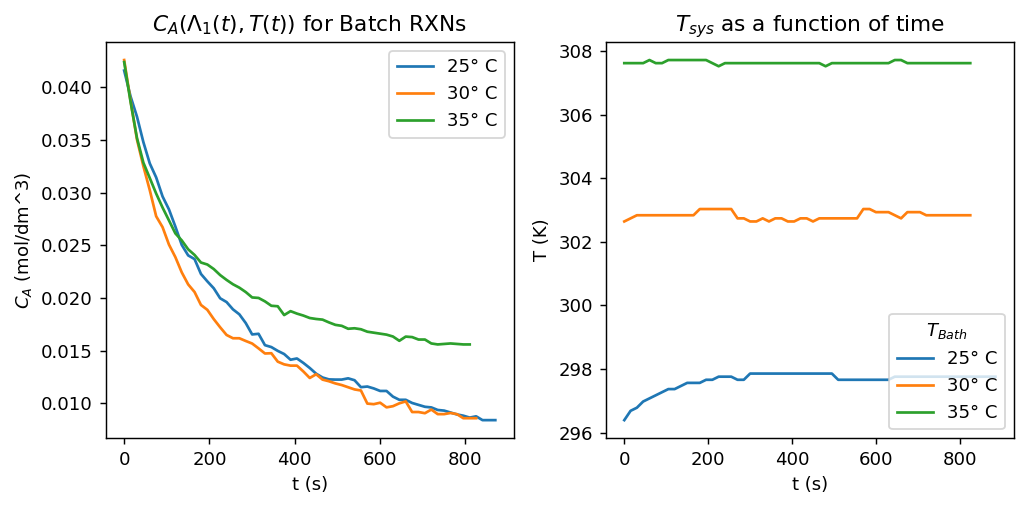

In [9]:
# Plot the interpolated total concentration as a function of time

C_a1 = tot_interp_C(run1_T, run1_L)
C_a2 = tot_interp_C(run2_T, run2_L)
C_a3 = tot_interp_C(run3_T, run3_L)

time_vec1 = np.arange(0, (len(run1_T))*15, 15)
time_vec2 = np.arange(0, (len(run2_T))*15, 15)
time_vec3 = np.arange(0, (len(run3_T))*15, 15)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(time_vec1[:-1], C_a1[1:])
ax[0].plot(time_vec2, C_a2)
ax[0].plot(time_vec3[:-1], C_a3[1:])

ax[0].set_xlabel('t (s)')
ax[0].set_ylabel(r'$C_A$ (mol/dm^3)')
ax[0].set_title(r'$C_A(\Lambda_1(t), T(t))$ for Batch RXNs')
ax[0].legend(['25° C','30° C', '35° C'])

ax[1].plot(time_vec1, run1_T)
ax[1].plot(time_vec2, run2_T)
ax[1].plot(time_vec3, run3_T)
ax[1].set_xlabel('t (s)')
ax[1].set_ylabel(r'T (K)')
ax[1].set_title(r'$T_{sys}$ as a function of time')
ax[1].legend(['25° C','30° C', '35° C'], loc='lower right', title=r'$T_{Bath}$')

plt.tight_layout()

# plt.plot(time_vec2, testResult2)
# plt.xlabel('t (s)')
# plt.ylabel(r'$C_A$ (mol/$dm^3$)')
# plt.title(r'$C_A(\Lambda_1(t), T(t))$ for 30° Batch RXN')

In [10]:
# plt.scatter(time_vec3, C_a3)
# plt.xlabel('t (s)')
# plt.ylabel(r'$C_A$ (mol/$dm^3$)')
# plt.title(r'$C_A(\Lambda_1(t), T(t))$ for 35° Batch RXN')

### Analyzing C_A vs t data to find rate constants

For each Temperature, the C_A(t) should follow the generic rate law:
$$-r_A = -\frac{d}{dt}(C_A) = k C_A^\alpha C_B^\beta$$

Where 
$$C_A = C_{A0}(1 - X)$$

$$C_B = C_{B0} - C_{A0}X$$

$$C_B = C_{B0} + C_{A} - C_{A0}$$

Plugging into the generic rate law
$$ -\frac{d}{dt}(C_A) = k C_A^\alpha (C_A + C_{B0}-C_{A0})^\beta$$

Then to find the rate constant and rate parameters, we use the following two numerical methods:


1) we fit each reaction rate to the generic rate law using scipy.optimize's non-linear least squares `curve_fit` method


2) we approximate the difference in initial concentrations of the reactants as negligible to perform a least squares linear regression
$$C_{B0} - C_{A0} \approx 0$$
$$\Rightarrow -\frac{d}{dt}(C_A)= k C_A^{\alpha+\beta}$$

$$\log(-\frac{d}{dt}(C_A)) = log(k) + (\alpha + \beta)\log(C_A))




#### 1) Fitting parameters via `curve_fit`

In [11]:
# Performing curve_fit on gradient of concentration vs concentration to find the rate parameters

grad_C_a1 = np.gradient(C_a1, time_vec1)
grad_C_a2 = np.gradient(C_a2, time_vec2)
grad_C_a3 = np.gradient(C_a3, time_vec3)

# Molarity of EtOAc from density at 25° C
EtOAc_M = 0.902/88.106*1e3 # (g/mL) / (g/mol) * (mL/L) 

# Initial concentrations of A and B
C_A0 = 0.4975*0.1/1
C_B0 = 0.00488*EtOAc_M/1

def generic_ratelaw(C_A, k, alpha, beta):
    return k * C_A**alpha * (C_A + C_B0 - C_A0)**beta

# Using scipys curve_fit function to fit the data to the generic rate law with the initial guesses of k = 1, alpha = 1, beta = 1
popt_T1, pcov_T1 = curve_fit(generic_ratelaw, C_a1, -1*grad_C_a1, p0=[0.2, 1, 1], bounds=((0, 0, 0), (np.inf, 3, 3)))
popt_T2, pcov_T2 = curve_fit(generic_ratelaw, C_a2, -1*grad_C_a2, p0=[0.2, 1, 1], bounds=((0, 0, 0), (np.inf, 3, 3)))
popt_T3, pcov_T3 = curve_fit(generic_ratelaw, C_a3[2:], -1*grad_C_a3[2:], p0=[0.3, 1, 1], bounds=((0, 0, 0), (np.inf, 3, 3)))

print('RXN Fit parameters: [k, alpha, beta] [k_err, alpha_err, beta_err]]')
print('25° C params: ', popt_T1, np.sqrt(np.diag(pcov_T1)))
print('30° C params: ', popt_T2, np.sqrt(np.diag(pcov_T2)))
print('35° C params: ', popt_T3, np.sqrt(np.diag(pcov_T3)))

RXN Fit parameters: [k, alpha, beta] [k_err, alpha_err, beta_err]]
25° C params:  [0.11662656 1.01444771 1.0196248 ] [ 0.11605533 42.72505173 43.08825562]
30° C params:  [0.2149028  1.05444468 1.05268396] [ 0.22286754 42.53649775 42.91134843]
35° C params:  [0.71163035 1.28008686 1.27381566] [  2.83986513 183.95049218 185.4525029 ]


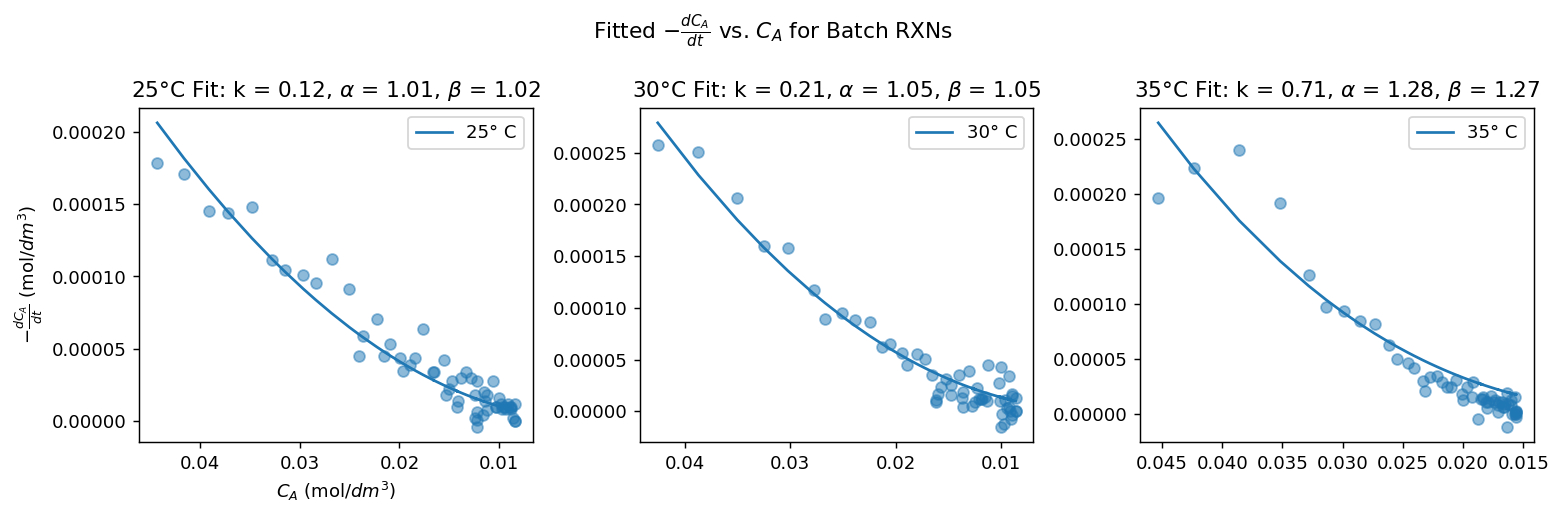

In [12]:
# Plotting the curve_fit of the generic rate law vs C_A
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(C_a1, generic_ratelaw(C_a1, *popt_T1))
ax[0].scatter(C_a1, -1*grad_C_a1, alpha=0.5)
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$C_A$ (mol/$dm^3$)')
ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[0].legend(['25° C'])
ax[0].set_title(r'25°C Fit: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T1[0], popt_T1[1], popt_T1[2]))

ax[1].plot(C_a2, generic_ratelaw(C_a2, *popt_T2))
ax[1].scatter(C_a2, -1*grad_C_a2, alpha=0.5)
ax[1].invert_xaxis()
# ax[1].set_xlabel(r'$C_A$ (mol/$dm^3$)')
# ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[1].legend(['30° C'])
ax[1].set_title(r'30°C Fit: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T2[0], popt_T2[1], popt_T2[2]))

ax[2].plot(C_a3, generic_ratelaw(C_a3, *popt_T3))
ax[2].scatter(C_a3, -1*grad_C_a3, alpha=0.5)
ax[2].invert_xaxis()
# ax[2].set_xlabel(r'$C_A$ (mol/$dm^3$)')
# ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[2].legend(['35° C'])
ax[2].set_title(r'35°C Fit: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T3[0], popt_T3[1], popt_T3[2]))

plt.suptitle(r'Fitted $-\frac{dC_A}{dt}$ vs. $C_A$ for Batch RXNs')
plt.tight_layout()

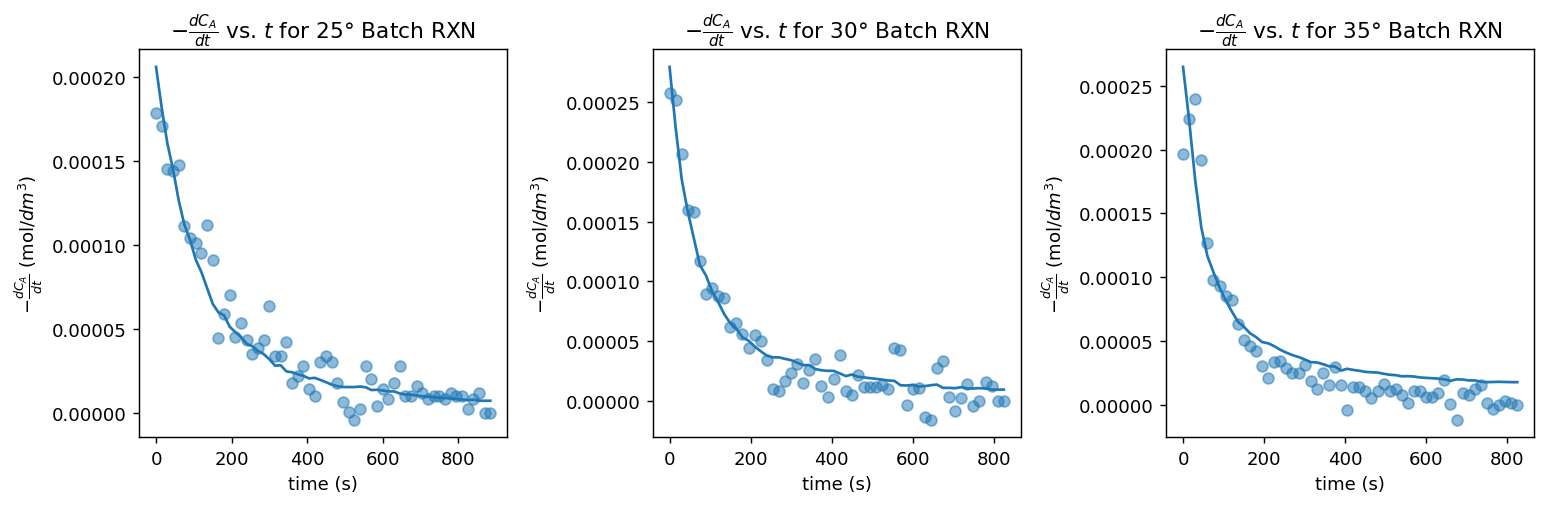

In [25]:
# Plotting the curve_fit of the generic rate law vs time
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].scatter(time_vec1, grad_C_a1 * -1, alpha=0.5)
ax[0].plot(time_vec1, generic_ratelaw(C_a1, *popt_T1))
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[0].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 25° Batch RXN')

ax[1].scatter(time_vec2, grad_C_a2 * -1, alpha=0.5)
ax[1].plot(time_vec2, generic_ratelaw(C_a2, *popt_T2))
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[1].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 30° Batch RXN')

ax[2].scatter(time_vec3, grad_C_a3 * -1, alpha=0.5)
ax[2].plot(time_vec3, generic_ratelaw(C_a3, *popt_T3))
ax[2].set_xlabel('time (s)')
ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[2].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 35° Batch RXN')
plt.tight_layout()


In [14]:
# Using curve_fit while constraining reaction orders of A and B to 1, to find the rate constant k

popt_T1_constr, pcov_T1_constr = curve_fit(generic_ratelaw, C_a1, -1*grad_C_a1, p0=[0.1, 1, 1], bounds=((0, 1, 1), (np.inf, 1.001, 1.1)))
popt_T2_constr, pcov_T2_constr = curve_fit(generic_ratelaw, C_a2, -1*grad_C_a2, p0=[0.1, 1, 1], bounds=((0, 1, 1), (np.inf, 1.001, 1.1)))
popt_T3_constr, pcov_T3_constr = curve_fit(generic_ratelaw, C_a3, -1*grad_C_a3, p0=[0.1, 1, 1], bounds=((0, 1, 1), (np.inf, 1.001, 1.1)))

# print(popt_T1_constr)
# print(popt_T2_constr)
# print(popt_T3_constr)

print('RXN Fit parameters: [k, alpha, beta] [k_err, alpha_err, beta_err]]')
print('25° C params: ', popt_T1_constr, np.sqrt(np.diag(pcov_T1_constr)))
print('30° C params: ', popt_T2_constr, np.sqrt(np.diag(pcov_T2_constr)))
print('35° C params: ', popt_T3_constr, np.sqrt(np.diag(pcov_T3_constr)))

RXN Fit parameters: [k, alpha, beta] [k_err, alpha_err, beta_err]]
25° C params:  [0.10454166 1.         1.        ] [ 0.09987227 40.64284759 40.99082951]
30° C params:  [0.14909839 1.         1.        ] [ 0.15489784 41.47852895 41.85177337]
35° C params:  [0.1 1.  1. ] [  0.30389683 155.14723574 156.32729407]


In [15]:
# Plotting the constrained curve fits; they are not as good as the unconstrained fits

# fig, ax = plt.subplots(1,3, figsize=(12,4))
# ax[0].scatter(C_a1, -1*grad_C_a1, color='blue', alpha=0.5)
# ax[0].plot(C_a1, generic_ratelaw(C_a1, *popt_T1_constr), color='red', linewidth=2.2)
# ax[0].set_xlabel(r'$C_A$')
# ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$')
# ax[0].legend(['Data', 'Constrained Fit'], loc='upper right')
# ax[0].set_title(r'25° C Fit: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T1_constr[0], popt_T1_constr[1], popt_T1_constr[2]))

# ax[1].scatter(C_a2, -1*grad_C_a2, color='blue', alpha=0.5)
# ax[1].plot(C_a2, generic_ratelaw(C_a2, *popt_T2_constr), color='red', linewidth=2.2)
# ax[1].set_xlabel(r'$C_A$')
# ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$')
# ax[1].legend(['Data', 'Constrained Fit'], loc='upper right')
# ax[1].set_title(r'30° C: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T2_constr[0], popt_T2_constr[1], popt_T2_constr[2]))

# ax[2].scatter(C_a3, -1*grad_C_a3, color='blue', alpha=0.5)
# ax[2].plot(C_a3, generic_ratelaw(C_a3, *popt_T3_constr), color='red', linewidth=2.2)
# ax[2].set_xlabel(r'$C_A$')
# ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$')
# ax[2].legend(['Data', 'Constrained Fit'], loc='upper right')
# ax[2].set_title(r'35° C: k = %.2f, $\alpha$ = %.2f, $\beta$ = %.2f' % (popt_T3_constr[0], popt_T3_constr[1], popt_T3_constr[2]))

# plt.suptitle(r'Constrained Curve Fitting of $-\frac{dC_A}{dt}$ vs. $C_A$')
# plt.tight_layout()

#### 2) Fitting Parameters via Linear Regression of $\log(-\frac{dC_A}{dt})$ vs $C_A$

In [16]:
# Performing a linear regression on the negative log of the gradient of C_A vs C_A

# smoothing concentration data to remove noise for log of derivatives via Savitzky-Golay filter
smooth_C_a1 = savgol_filter(C_a1, 21, 3)
smooth_C_a2 = savgol_filter(C_a2, 21, 3)
smooth_C_a3 = savgol_filter(C_a3, 21, 3)

neglog_grad_C_a1 = np.log(np.gradient(smooth_C_a1, 15) * -1)
neglog_grad_C_a2 = np.log(np.gradient(smooth_C_a2, 15) * -1)
neglog_grad_C_a3 = np.log(np.gradient(smooth_C_a3, 15) * -1)

# performing least squares linear regression on the negative log of the gradient of smoothened C_A vs C_A
z1 = np.polyfit(np.log(smooth_C_a1), neglog_grad_C_a1, 1)
z2 = np.polyfit(np.log(smooth_C_a2), neglog_grad_C_a2, 1)
z3 = np.polyfit(np.log(smooth_C_a3), neglog_grad_C_a3, 1)

poly1 = np.poly1d(z1)
poly2 = np.poly1d(z2)
poly3 = np.poly1d(z3)

print(r'RXN Fit parameters: [k, (alpha + beta)]')
print('25° C params: [%.4f %.4f]' % (np.exp(z1[1]), z1[0]))
print('30° C params: [%.4f, %.4f]' % (np.exp(z2[1]), z2[0]))
print('35° C params: [%.4f, %.4f]' % (np.exp(z3[1]), z3[0]))

# Removing the last 15 points from the data to see if the fit improves
z3_trunc = np.polyfit(np.log(smooth_C_a3)[:-15], neglog_grad_C_a3[:-15], 1)
poly3_trunc = np.poly1d(z3_trunc)
print('35° C params (truncated): [%.4f, %.4f]' % (np.exp(z3_trunc[1]), z3_trunc[0]))


RXN Fit parameters: [k, (alpha + beta)]
25° C params: [0.1517 2.0824]
30° C params: [0.6400, 2.4154]
35° C params: [509.1207, 4.4311]
35° C params (truncated): [60.5685, 3.8415]


In [17]:
# Taking Rough logarithms and Smoothing analysis (not-in-domain errors thrown)

neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
neglog_grad_C_a3_rough = np.log(np.gradient(C_a3, 15) * -1)

# print(neglog_grad_C_a1.shape)
# print(neglog_grad_C_a1_rough.shape)
# plt.scatter(time_vec1, neglog_grad_C_a1, color='blue')
# plt.plot(time_vec2, neglog_grad_C_a2, color='orange')
# plt.plot(time_vec3, neglog_grad_C_a3, color='green')
# plt.scatter(time_vec1, np.log(np.gradient(C_a1, 15) * -1), color='blue')
# plt.plot(time_vec2, np.log(np.gradient(C_a2, 15) * -1), color='orange')
# plt.plot(time_vec3, np.log(np.gradient(C_a3, 15) * -1), color='green')

/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_14102/4119997299.py:3: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_14102/4119997299.py:3: RuntimeWarning: invalid value encountered in log
  neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_14102/4119997299.py:4: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_14102/4119997299.py:4: RuntimeWarning: invalid value encountered in log
  neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_14102/4119997299.py:5: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a3_rough = np.log(np.gradient(C_a3, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd6

In [18]:
# Alternative method of preparing data for linear regression via removing nan values (not used)

# remove_nan =  (lambda v: v==v) # removes nan values from the array
# C_a3_copy = C_a3[remove_nan(neglog_grad_C_a3_rough)]
# neglog_grad_C_a3_rough = neglog_grad_C_a3_rough[remove_nan(neglog_grad_C_a3_rough)]

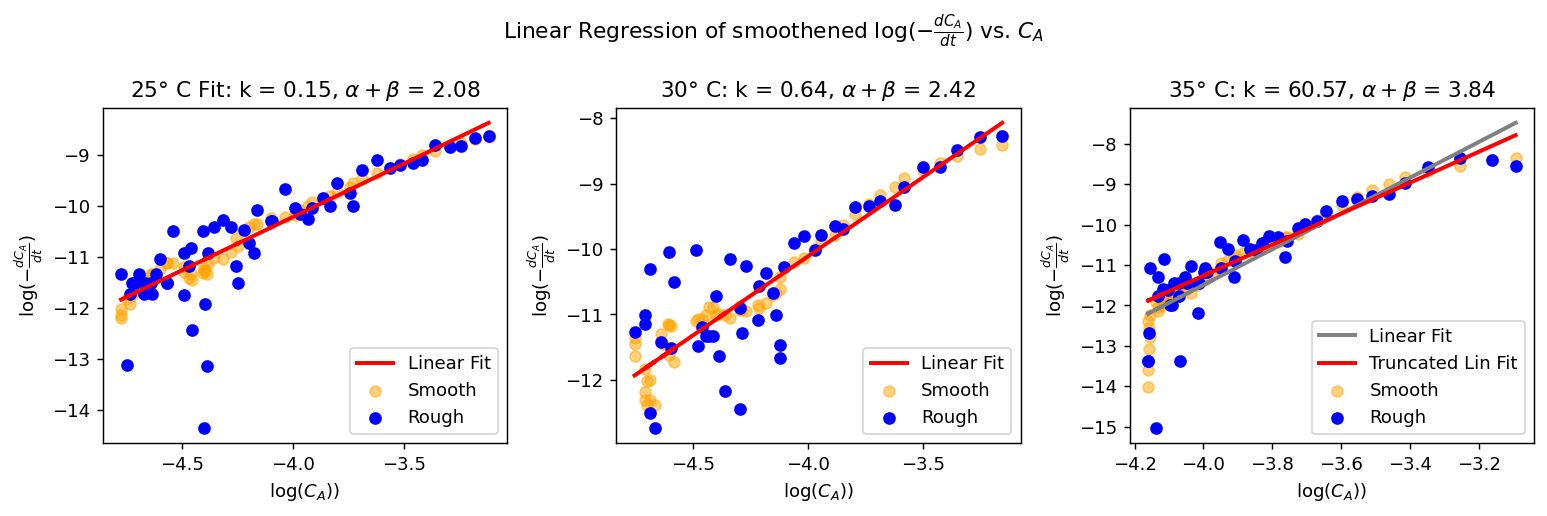

In [19]:
# Plotting the linear Regressions of the negative log of the gradient of C_A vs log C_A
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(np.log(C_a1), poly1(np.log(C_a1)), color='red', linewidth=2.2)
ax[0].scatter(np.log(C_a1), neglog_grad_C_a1, color='orange', alpha=0.5)
ax[0].scatter(np.log(C_a1), neglog_grad_C_a1_rough, color='blue', alpha=1)
ax[0].set_xlabel(r'$\log(C_A)$)')
ax[0].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[0].legend(['Linear Fit', 'Smooth', 'Rough'], loc='lower right')
ax[0].set_title(r'25° C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(z1[1]), z1[0]))

ax[1].plot(np.log(C_a2), poly2(np.log(C_a2)), color='red', linewidth=2.2)
ax[1].scatter(np.log(C_a2), neglog_grad_C_a2, color='orange', alpha=0.5)
ax[1].scatter(np.log(C_a2), neglog_grad_C_a2_rough, color='blue', alpha=1)
ax[1].set_xlabel(r'$\log(C_A)$)')
ax[1].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[1].legend(['Linear Fit', 'Smooth', 'Rough'], loc='lower right')
ax[1].set_title(r'30° C: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(z2[1]), z2[0]))

ax[2].plot(np.log(C_a3), poly3(np.log(C_a3)), color='grey', linewidth=2.2)
ax[2].plot(np.log(C_a3), poly3_trunc(np.log(C_a3)), color='red', linewidth=2.2)
ax[2].scatter(np.log(C_a3), neglog_grad_C_a3, color='orange', alpha=0.5)
ax[2].scatter(np.log(C_a3), neglog_grad_C_a3_rough, color='blue', alpha=1)
ax[2].legend(['Linear Fit', 'Truncated Lin Fit', 'Smooth', 'Rough'], loc='lower right')
ax[2].set_xlabel(r'$\log(C_A)$)')
ax[2].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[2].set_title(r'35° C: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(z3_trunc[1]), z3_trunc[0]))


plt.suptitle(r'Linear Regression of smoothened $\log(-\frac{dC_A}{dt})$ vs. $C_A$')
plt.tight_layout()


### Finding the Arrhenius Equation Parameters

The temperarture dependence of the reaction rate constant, k, is modeled by the Arrhenius equation.
$$ k(T) = A\exp(-\frac{E_A}{RT}) $$
Plotting our experimental values for $k(\bar T_{sys})$:

Text(0.5, 1.0, 'Arrhenius Plot of $k$ vs. $\\bar T_{sys}$')

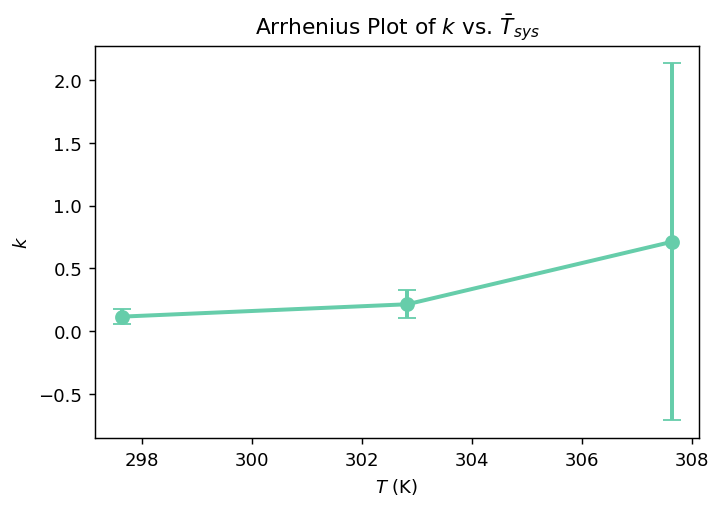

In [26]:
# Plotting the Arrhenius plot of k vs T
Temps = np.array([25, 30, 35]) + 273.15
mean_Temps = np.array([np.mean(run1_T), np.mean(run2_T), np.mean(run3_T)])
ks = np.array([popt_T1[0], popt_T2[0], popt_T3[0]])
k_err = np.array([np.sqrt(np.diag(pcov_T1))[0], np.sqrt(np.diag(pcov_T2))[0], np.sqrt(np.diag(pcov_T3))[0]])

plt.scatter(mean_Temps, ks, color='mediumaquamarine', linewidth=2.2)
plt.errorbar(mean_Temps, ks, yerr=k_err/2, color='mediumaquamarine', linewidth=2.2, capsize=5)
plt.xlabel(r'$T$ (K)')
plt.ylabel(r'$k$')
plt.title(r'Arrhenius Plot of $k$ vs. $\bar T_{sys}$')

Given the much greater error in the rate constant for the 35 °C RXN data, we opt to use the 2-point Arrhenius Equation for the first two temperature values to determine the Arrhenius constants for the model reaction.

$$\log(\frac{k(T_1)}{k(T_2)}) = \frac{E_a}{R} (\frac{1}{T_2}-\frac{1}{T_1})$$

In [33]:
R = 8.314 # J/mol K
E_a = R * np.log(popt_T1[0]/popt_T2[0]) * (1/mean_Temps[1] - 1/mean_Temps[0])**-1
E_a_error = R * np.log((popt_T1[0] + (k_err[0])**2)/(popt_T2[0] - (k_err[1]**2))) * (1/mean_Temps[1] - 1/mean_Temps[0])**-1 - E_a

A = popt_T1[0] * np.exp(E_a/(R*mean_Temps[0]))
A_error = popt_T1[0] * np.exp((E_a + E_a_error)/(R*mean_Temps[0])) - A

print(r'E_a = %.2f ± %.2f kJ/mol' % (E_a/1000, np.abs(E_a_error/1000)))
print(r'A = %.2e ± %.2e' % (A, np.abs(A_error)))

E_a = 88.26 ± 53.73 kJ/mol
A = 3.60e+14 ± 3.60e+14


## Continuous Flow Reactor

In [22]:
# Reading in the CFR data from the csv file

# Reading in experimental batch data from excel file
CFR_data = pd.read_excel('Lab 1 Data Clean.xlsx', sheet_name=3)

# print(run_data[1].columns)

CFR_lambda = np.array(run_data[0]['Measured \nConductivity \n \n0 - 20 [mS]'])
CFR_T = np.array(run_data[1]['Reactor \nTemp. \n \n[°C]']) + 273.15
CFR_nu = np.array(run_data[0]['Reactor \nStirring \nSpeed \n \n[rpm]'])

### Relating Concentration to conductivity and temperature data for CFR

Analyzing conductivity-temperature data for the Continuous Flow reactors:

Continuous Flow Reactor design equation
$$ V = \frac{F_{A0}(X_{out} - X_{in})}{(-r_A)_{out}} $$

$$ F_{i0} = C_{i0} \nu $$
With the following initial conditions:

$\nu = (100, 200, 80)$ mL/min

$C_{A0} = C_{B0} = 0.1$ M


In [ ]:
# in progress...